In [79]:
# pip install ultralytics

In [80]:
# %%
import os
print("Current directory:", os.getcwd())

Current directory: /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src


In [81]:
# %%
yaml_path = "../dataset/dataset.yaml"

yaml_text = """
path: /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset
train: train/images
val: valid/images
test: test/images

names:
  0: tumor
"""

with open(yaml_path, "w") as f:
    f.write(yaml_text.strip())

print("dataset.yaml created at:", yaml_path)
print("----- YAML CONTENT -----")
print(yaml_text)

dataset.yaml created at: ../dataset/dataset.yaml
----- YAML CONTENT -----

path: /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset
train: train/images
val: valid/images
test: test/images

names:
  0: tumor



In [82]:
# %%
import os
print("YAML file exists:", os.path.exists("../dataset/dataset.yaml"))

YAML file exists: True


In [83]:
# %%
import torch

print("PyTorch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

PyTorch version: 2.9.1
MPS available: True
Using device: mps


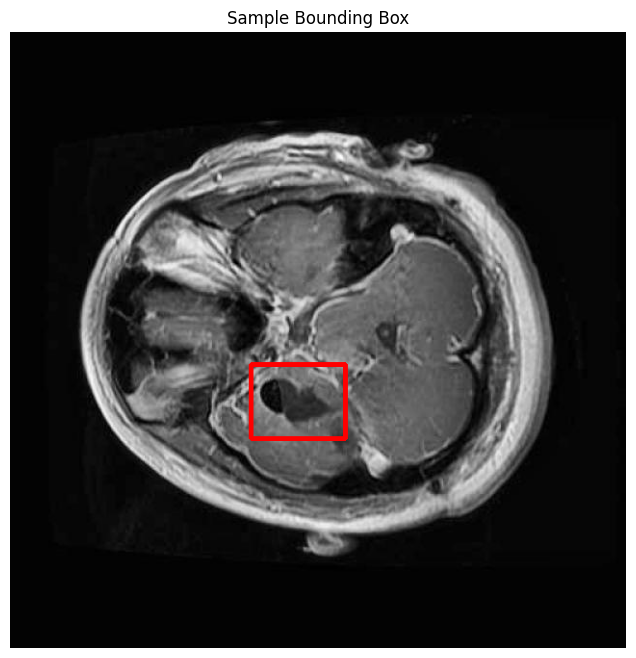

In [84]:
# %%
import json
import cv2
import matplotlib.pyplot as plt
import os
import random

ann_path = "../dataset/train/_annotations.coco.json"
with open(ann_path, "r") as f:
    coco = json.load(f)

def draw_box(img, bbox, color=(255, 0, 0), thickness=3):
    x, y, w, h = map(int, bbox)
    cv2.rectangle(img, (x, y), (x+w, y+h), color, thickness)

img_meta = random.choice(coco["images"])
img_fn = img_meta["file_name"]

img_path = os.path.join("../dataset/train/images", img_fn)

img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found at: {img_path}")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

anns = [ann for ann in coco["annotations"] if ann["image_id"] == img_meta["id"]]
for ann in anns:
    draw_box(img, ann["bbox"])

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Bounding Box")
plt.show()

We must convert COCO → YOLO.

In [85]:
# %%
import json
import os

def coco_to_yolo(coco_json_path, images_dir, labels_dir, class_id=0):
    os.makedirs(labels_dir, exist_ok=True)

    with open(coco_json_path, "r") as f:
        coco = json.load(f)

    image_sizes = {
        img["id"]: (img["width"], img["height"], img["file_name"])
        for img in coco["images"]
    }

    ann_by_img = {}
    for ann in coco["annotations"]:
        ann_by_img.setdefault(ann["image_id"], []).append(ann)

    count = 0

    for img_id, anns in ann_by_img.items():
        w, h, fname = image_sizes[img_id]

        label_path = os.path.join(
            labels_dir,
            fname.replace(".jpg", ".txt").replace(".png", ".txt")
        )

        with open(label_path, "w") as f:
            for ann in anns:
                x, y, bw, bh = ann["bbox"]

                cx = (x + bw/2) / w
                cy = (y + bh/2) / h
                nw = bw / w
                nh = bh / h

                f.write(f"{class_id} {cx} {cy} {nw} {nh}\n")

        count += 1

    print(f"Converted {count} labels → {labels_dir}")

In [86]:
# %%
project_root = os.path.dirname(os.getcwd())
dataset_root = os.path.join(project_root, "dataset")

# TRAIN
coco_to_yolo(
    coco_json_path=os.path.join(dataset_root, "train/_annotations.coco.json"),
    images_dir=os.path.join(dataset_root, "train/images"),
    labels_dir=os.path.join(dataset_root, "train/labels")
)

# VALID
coco_to_yolo(
    coco_json_path=os.path.join(dataset_root, "valid/_annotations.coco.json"),
    images_dir=os.path.join(dataset_root, "valid/images"),
    labels_dir=os.path.join(dataset_root, "valid/labels")
)

# TEST
os.makedirs(os.path.join(dataset_root, "test/labels"), exist_ok=True)
print("Prepared empty test labels folder.")

Converted 1501 labels → /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset/train/labels
Converted 429 labels → /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset/valid/labels
Prepared empty test labels folder.


In [87]:
# %%
import os

print("Train labels:", len(os.listdir("../dataset/train/labels")))
print("Valid labels:", len(os.listdir("../dataset/valid/labels")))

Train labels: 1501
Valid labels: 429


Data Cleaning:

In [94]:
import os

train_images = "../dataset/train/images"
train_labels = "../dataset/train/labels"

deleted = 0

for label_file in os.listdir(train_labels):
    if not label_file.endswith(".txt"):
        continue

    # Label file → expected image filename
    base = label_file.replace(".txt", "")
    # Roboflow sometimes uses weird "28_jpg.rf.XXXX" naming
    possible_files = [
        base + ".jpg",
        base + ".jpeg",
        base + ".png"
    ]

    exists = any(os.path.exists(os.path.join(train_images, f)) for f in possible_files)

    if not exists:
        os.remove(os.path.join(train_labels, label_file))
        deleted += 1

print(f"Cleaned {deleted} corrupted label files.")

Cleaned 0 corrupted label files.


Remove Cache Before Training:

In [ ]:
import glob, os

for cache in glob.glob("../dataset/**.cache", recursive=True):
    print("Deleting:", cache)
    os.remove(cache)

print("Done.")

 YOLO Training 

In [ ]:
from ultralytics import YOLO
import torch
import os

# --- FORCE DEVICE ---
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

# --- Correct yaml path ---
yaml_path = "../dataset/dataset.yaml"
assert os.path.exists(yaml_path), "dataset.yaml missing!"

# --- Load pretrained YOLOv8s ---
model = YOLO("yolov8s.pt")

# --- Train and SAVE to correct directory ---
results = model.train(
    data=yaml_path,
    epochs=25,
    imgsz=640,
    batch=16,
    patience=10,
    device=device,
    workers=4,
    project="../experiments",   # ⬅️ FIXED
    name="yolo_run7",           # ⬅️ FIXED
    save=True,
    save_period=1
)

print("Training complete. Outputs saved to ../experiments/yolo_run7")

Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 MPS (Apple M4 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../dataset/dataset.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_run7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

FileNotFoundError: Image Not Found /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset/train/images/28_jpg.rf.d00f6ef6907346b31d6abbd4f9fca951.jpg

 IoU Helper Function

In [91]:
# %%
import numpy as np

def box_iou_xyxy(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter = max(0, xB-xA) * max(0, yB-yA)

    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])

    union = area1 + area2 - inter
    if union <= 0:
        return 0

    return inter / union

Compute Raw IoU Per Epoch

In [ ]:
# ================================================
# RAW IoU EVALUATION FOR ALL EPOCHS (FIXED PATHS)
# ================================================
import numpy as np
import os, glob, json
from ultralytics import YOLO
from tqdm import tqdm
import pandas as pd

def box_iou_xyxy(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter = max(0, xB-xA) * max(0, yB-yA)
    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union = area1 + area2 - inter

    return inter/union if union > 0 else 0


# ===========================================================
# LOAD COCO GROUND TRUTH
# ===========================================================
coco_path = "../dataset/train/_annotations.coco.json"
with open(coco_path, "r") as f:
    coco = json.load(f)

gt_info = {}
for img in coco["images"]:
    gt_info[img["id"]] = {
        "width": img["width"],
        "height": img["height"],
        "boxes": []
    }

for ann in coco["annotations"]:
    img_id = ann["image_id"]
    x, y, w, h = ann["bbox"]
    gt_info[img_id]["boxes"].append([x, y, x+w, y+h])


# ===========================================================
# PREDICTION DIRECTORIES (CORRECTED)
# ===========================================================
exp_root = "../experiments/yolo_run7"
weights_dir = os.path.join(exp_root, "weights")
epoch_weights = sorted(glob.glob(os.path.join(weights_dir, "epoch*.pt")))

yaml_path = "../dataset/dataset.yaml"

results = []

print("Evaluating epochs…")
for w in tqdm(epoch_weights):
    epoch = int(os.path.basename(w).replace("epoch", "").replace(".pt", ""))

    model = YOLO(w)
    pred_dir = f"{exp_root}/epoch{epoch}_preds"

    model.val(
        data=yaml_path,
        save_txt=True,
        save_conf=True,
        project="../experiments/yolo_run7",
        name=f"epoch{epoch}_preds",
        exist_ok=True,
        verbose=False
    )

    pred_root = f"{pred_dir}/labels"
    all_ious = []

    for txt_file in glob.glob(pred_root + "/*.txt"):
        pred_name = os.path.basename(txt_file).replace(".txt", "")

        # Find matching COCO image
        matches = [
            img for img in coco["images"]
            if os.path.splitext(os.path.basename(img["file_name"]))[0].startswith(pred_name)
        ]
        if not matches:
            continue

        img_id = matches[0]["id"]
        W = gt_info[img_id]["width"]
        H = gt_info[img_id]["height"]

        preds = []
        with open(txt_file, "r") as f:
            for line in f:
                cls, xc, yc, bw, bh, conf = map(float, line.split())
                x1 = (xc - bw/2) * W
                y1 = (yc - bh/2) * H
                x2 = (xc + bw/2) * W
                y2 = (yc + bh/2) * H
                preds.append([x1, y1, x2, y2])

        for p in preds:
            for gt in gt_info[img_id]["boxes"]:
                all_ious.append(box_iou_xyxy(p, gt))

    epoch_iou = float(np.mean(all_ious)) if all_ious else 0.0
    print(f"Epoch {epoch} — Raw IoU = {epoch_iou:.4f}")

    results.append({"epoch": epoch, "raw_iou": epoch_iou})


df = pd.DataFrame(results).sort_values("epoch")
df.to_csv("../experiments/yolo_run7/raw_iou_results.csv", index=False)

print("\nBest IoU:", df["raw_iou"].max())

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M4 Max)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 187.3±43.8 MB/s, size: 38.8 KB)
val: Scanning /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset/valid/labels.cache... 429 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 882.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 4.7s/it 2:084.8ss
                   all        429        429      0.307      0.269      0.203      0.094
Speed: 0.6ms preprocess, 279.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/src/experiments/yolo_run7/epoch0_preds


Evaluating:   5%|▌         | 1/19 [02:08<38:33, 128.50s/it]

Epoch 0 — Raw IoU = 0.0000
Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M4 Max)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 209.9±83.7 MB/s, size: 42.5 KB)
val: Scanning /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset/valid/labels.cache... 429 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 1.7Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 4.6s/it 2:054.8ss
                   all        429        429      0.272       0.27      0.177     0.0937
Speed: 0.5ms preprocess, 282.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/src/experiments/yolo_run7/epoch1_preds


Evaluating:  11%|█         | 2/19 [04:14<35:58, 127.00s/it]

Epoch 1 — Raw IoU = 0.0000
Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M4 Max)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 178.7±58.2 MB/s, size: 38.9 KB)
val: Scanning /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset/valid/labels.cache... 429 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 1.6Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 4.6s/it 2:054.8ss
                   all        429        429      0.838      0.692       0.82      0.453
Speed: 0.4ms preprocess, 287.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/src/experiments/yolo_run7/epoch10_preds


Evaluating:  16%|█▌        | 3/19 [06:20<33:45, 126.61s/it]

Epoch 10 — Raw IoU = 0.0000
Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M4 Max)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 170.2±25.0 MB/s, size: 31.7 KB)
val: Scanning /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset/valid/labels.cache... 429 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 1.6Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 4.7s/it 2:074.9ss
                   all        429        429      0.815      0.669      0.796      0.456
Speed: 0.5ms preprocess, 292.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/src/experiments/yolo_run7/epoch11_preds


Evaluating:  21%|██        | 4/19 [08:28<31:48, 127.27s/it]

Epoch 11 — Raw IoU = 0.0000
Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M4 Max)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 154.8±50.3 MB/s, size: 36.2 KB)
val: Scanning /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset/valid/labels.cache... 429 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 1.6Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 4.7s/it 2:074.7ss
                   all        429        429      0.832      0.709       0.82      0.452
Speed: 0.5ms preprocess, 291.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/src/experiments/yolo_run7/epoch12_preds


Evaluating:  26%|██▋       | 5/19 [10:36<29:44, 127.48s/it]

Epoch 12 — Raw IoU = 0.0000
Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M4 Max)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 191.0±35.9 MB/s, size: 41.9 KB)
val: Scanning /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/dataset/valid/labels.cache... 429 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 1.8Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 67% ━━━━━━━━──── 18/27 6.9s/it 1:29<1:02s


Evaluating:  26%|██▋       | 5/19 [12:05<33:52, 145.18s/it]


KeyboardInterrupt: 

In [93]:
import json

coco = json.load(open("../dataset/train/_annotations.coco.json"))

print("Example COCO entry:")
for i in range(10):
    print(coco["images"][i])

Example COCO entry:
{'id': 0, 'license': 1, 'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
{'id': 1, 'license': 1, 'file_name': '2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
{'id': 2, 'license': 1, 'file_name': '2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
{'id': 3, 'license': 1, 'file_name': '2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
{'id': 4, 'license': 1, 'file_name': '2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}
{'id': 5, 'license': 1, 'file_name': '2161_jpg.rf.3be4125d1ffe011c0ed462d9fe0d2152.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:0